In [1]:
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
#from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import image_utils


import math
import random
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

2023-07-17 18:30:18.829711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 18:30:20.822536: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-17 18:30:20.822616: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-17 18:30:20.822624: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)        #输入大小设为（224,224,3）
BATCHSIZE=128	#could try 128 or 32  #批量大小设置为128

#Normalization
#ImageDataGenerator，rescale的作用是对图片的每个像素值均乘上这个放缩因子，这个操作在所有其它变换操作之前执行，在一些模型当中，
#直接输入原图的像素值可能会落入激活函数的“死亡区”，因此设置放缩因子为1/255，把像素值放缩到0和1之间有利于模型的收敛，避免神经元“死亡”。
train_datagen = ImageDataGenerator(rescale=1./255)  ##归一化

test_datagen = ImageDataGenerator(rescale=1./255)   # #不增强验证数据

train_generator = train_datagen.flow_from_directory(  #从指定的目录中生成训练图像
        './dataset/train_224',##训练文件路径--文件夹下多分类文件夹
        target_size=TARGET_SIZE,                     #目标大小设置为(224,224)，图像统一尺寸
        batch_size=BATCHSIZE,                        #batch数据的大小,默认32
        class_mode='categorical')                   #返回标签数组形式 'binary'二进制；
validation_generator = test_datagen.flow_from_directory(  #从指定的目录中生成测试图像
        './dataset/test_224',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 4313 images belonging to 5 classes.
Found 1024 images belonging to 5 classes.


In [3]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        #创建一个图
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')#plt.plot(x,y)，这个将数据画成曲线
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)#设置网格形式
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')#给x，y轴加注释
        plt.legend(loc="upper right")#设置图例显示位置
        plt.savefig('acc-loss.jpg', dpi=800)
        plt.show()

In [4]:
#创建一个LossHistory的实例
history_this= LossHistory()

In [5]:
def cnn_by_own(input_shape,num_class,epochs,savepath='./dataset/model_own.h5'):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    #verbose:日志的显示模式，取 1 时表示“进度条模式”，取2时表示“每轮一行”，取0时表示“安静模式”；
    hist=model.fit_generator(
        train_generator,#generator：指需要训练的训练集
        steps_per_epoch=len(train_generator), #steps_per_epochs:是指在每个epoch中生成器执行生成数据的次数
        epochs=epochs,
        validation_data=validation_generator, #validation_data：验证集
        validation_steps=len(validation_generator),#当validation_data为生成器时，本参数指定验证集的生成器返回次数，validation_steps：指验证集的情况，类似于steps_per_epoch
        callbacks=[history_this],
    )
    model.save('my_model.h5')
    model = load_model('my_model.h5')

2023-07-17 18:32:51.302292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 18:32:51.391859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 18:32:51.392140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 18:32:51.394156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/20


2023-07-17 18:32:56.364224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-07-17 18:32:58.303523: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-07-17 18:32:58.303566: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-07-17 18:32:58.303639: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-07-17 18:33:01.282245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-17 18:33:01.674882: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7faef40ef1a

34/34 [==============================] - 25s 371ms/step - loss: 1.0099 - accuracy: 0.5476 - val_loss: 0.3828 - val_accuracy: 0.8799
Epoch 2/20
34/34 [==============================] - 10s 300ms/step - loss: 0.3324 - accuracy: 0.8834 - val_loss: 0.0922 - val_accuracy: 0.9551
Epoch 3/20
34/34 [==============================] - 10s 304ms/step - loss: 0.3807 - accuracy: 0.9040 - val_loss: 0.4303 - val_accuracy: 0.6787
Epoch 4/20
34/34 [==============================] - 11s 308ms/step - loss: 0.2482 - accuracy: 0.9149 - val_loss: 0.0247 - val_accuracy: 0.9971
Epoch 5/20
34/34 [==============================] - 10s 305ms/step - loss: 0.0276 - accuracy: 0.9900 - val_loss: 0.0078 - val_accuracy: 0.9961
Epoch 6/20
34/34 [==============================] - 10s 303ms/step - loss: 0.0288 - accuracy: 0.9919 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 10s 304ms/step - loss: 0.0062 - accuracy: 0.9977 - val_loss: 0.0041 - val_accuracy: 0.9971
Epoch 8/20

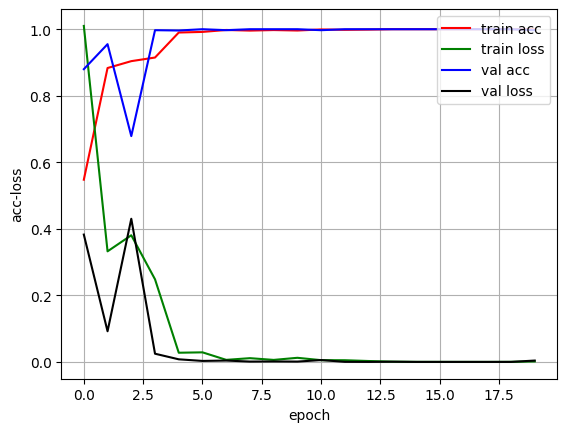

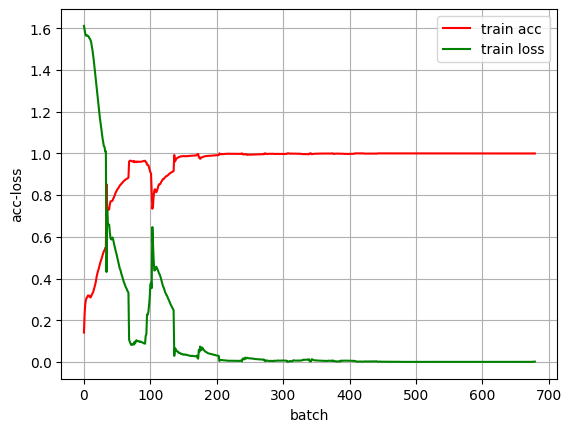

In [6]:
cnn_by_own(input_shape=INPUT_SIZE,num_class=5,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [52]:
!pip install hyperopt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [65]:

def vgg16(num_class, epochs=20, frozen=15, lr=0.001, patience=2, dropout_rate=0.5, verbose=0, savepath='./VGG16.h5', history=history_this, input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model = Dense(units=256, activation='relu')(model)
    model = Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=patience, verbose=verbose, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping, saveBestModel, history],
        verbose=verbose
    )
    return hist, model

def prediction(vgg_model):
#read images from validation folder
    rootdir = './dataset/test_224/'
    test_laels = []
    test_images=[]
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
                continue
            test_laels.append(subdir.split('/')[-1])
            test_images.append(os.path.join(subdir, file))

    predict=[]
    length=len(test_images)
    label=validation_generator.class_indices
    label={v: k for k, v in label.items()}
    for i in range(length):
        inputimg=test_images[i]
        test_batch=[]
        thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
        #print(thisimg)
        test_shape=(1,)+thisimg.shape
        thisimg=thisimg.reshape(test_shape)
        vgg_model_batch=vgg_model.predict(thisimg) #use master model to process the input image
        #generate result by model 1
        prob=vgg_model_batch[0,np.argmax(vgg_model_batch,axis=1)[0]]
        res=label[np.argmax(vgg_model_batch,axis=1)[0]]
        predict.append(res)
    acc=accuracy_score(test_laels,predict)
    return acc

def objective(params):
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    frozen = params['frozen']
    epochs = params['epochs']
    patience = params['patience']
    lr = params['lr']
    dropout_rate = params['dropout_rate']

    hist, model = vgg16(num_class=5, frozen=frozen, epochs=epochs, patience=patience, lr=lr, dropout_rate=dropout_rate)
    acc = prediction(vgg_model=model)

    print('accuracy: %s' % acc)
    return {'loss': -acc, 'status': STATUS_OK, 'accuracy': acc}


In [68]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Disable TensorFlow logs

# Rest of your code

t1 = time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=Trials(),
            verbose=0)  # Set verbose=0 to suppress output
t2 = time.time()

print("Hyperopt estimated optimum {}".format(best))
print("Time: " + str(t2 - t1))
'''
t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=Trials())
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))
'''

1/1 [==============================] - 0s 23ms/step
accuracy: 1.0


/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
accuracy: 1.0


/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
accuracy: 1.0


/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
accuracy: 1.0


/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 18ms/step
accuracy: 1.0


/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
accuracy: 1.0


/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
accuracy: 1.0


/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 18ms/step
accuracy: 1.0


/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 17ms/step
accuracy: 0.9990234375


/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
accuracy: 1.0
Hyperopt estimated optimum {'dropout_rate': 0.5, 'epochs': 20.0, 'frozen': 16.0, 'lr': 0.004, 'patience': 3.0}
Time: 1372.7469055652618


'\nt1=time.time()\nbest = fmin(fn=objective,\n            space=space,\n            algo=tpe.suggest,\n            max_evals=10,\n            trials=Trials())\nprint("Hyperopt estimated optimum {}".format(best))\nt2=time.time()\nprint("Time: "+str(t2-t1))\n'

In [84]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def resnet(num_class, epochs=20,frozen=120,patience=2, dropout_rate=0.5,verbose=0,lr=0.000001, savepath='./resnet.h5', history=history_this, input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model = Dense(units=256, activation='relu')(model)
    model = Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=patience, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        use_multiprocessing=True,
        callbacks=[earlyStopping, saveBestModel, history]
    )
    return hist, model

def prediction(resnet_model):
    # read images from validation folder
    rootdir = './dataset/test_224/'
    test_labels = []
    test_images = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not (file.endswith(".jpeg") or file.endswith(".jpg") or file.endswith(".png")):
                continue
            test_labels.append(subdir.split('/')[-1])
            test_images.append(os.path.join(subdir, file))

    predict = []
    length = len(test_images)
    label = validation_generator.class_indices
    label = {v: k for k, v in label.items()}
    for i in range(length):
        inputimg = test_images[i]
        test_batch = []
        thisimg = np.array(Image.open(inputimg)) / 255
        test_shape = (1,) + thisimg.shape
        thisimg = thisimg.reshape(test_shape)
        resnet_model_batch = resnet_model.predict(thisimg)
        prob = resnet_model_batch[0, np.argmax(resnet_model_batch, axis=1)[0]]
        res = label[np.argmax(resnet_model_batch, axis=1)[0]]
        predict.append(res)
    acc = accuracy_score(test_labels, predict)
    return acc

def objective(params):
    params = {
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    epochs = params['epochs']
    patience = params['patience']
    lr = params['lr']
    dropout_rate = params['dropout_rate']

    hist, model = resnet(num_class=5, epochs=epochs, patience=patience, lr=lr, dropout_rate=dropout_rate)
    acc = prediction(resnet_model=model)

    print('accuracy: %s' % acc)
    return {'loss': -acc, 'status': STATUS_OK, 'accuracy': acc}



In [ ]:
# Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 100, 150, 15),
    'epochs': hp.quniform('epochs', 15, 31, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.000001, 0.000006, 0.000001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Disable TensorFlow logs

# Rest of your code

t1 = time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=Trials(),
            verbose=0)  # Set verbose=0 to suppress output
t2 = time.time()

print("Hyperopt estimated optimum {}".format(best))
print("Time: " + str(t2 - t1))



/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/958624459.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.8226
Epoch 1: val_accuracy improved from -inf to 0.09863, saving model to ./resnet.h5
34/34 [==============================] - 30s 780ms/step - loss: 0.6010 - accuracy: 0.8226 - val_loss: 1.7006 - val_accuracy: 0.0986
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9715
Epoch 2: val_accuracy did not improve from 0.09863
34/34 [==============================] - 27s 770ms/step - loss: 0.1441 - accuracy: 0.9715 - val_loss: 1.6837 - val_accuracy: 0.0986
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9856
Epoch 3: val_accuracy improved from 0.09863 to 0.12793, saving model to ./resnet.h5
34/34 [==============================] - 22s 617ms/step - loss: 0.0785 - accuracy: 0.9856 - val_loss: 1.6659 - val_accuracy: 0.1279
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9926
Epoch 4: val

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/958624459.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/30
 1/34 [..............................] - ETA: 3:45 - loss: 1.8442 - accuracy: 0.1875

Process Keras_worker_ForkPoolWorker-856:
Process Keras_worker_ForkPoolWorker-869:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/environment/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/environment/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/environment/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/environment/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/environment/miniconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/environment/miniconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/environment/miniconda3/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()

In [82]:
def inception( num_class, epochs=20,frozen=35,patience=2, dropout_rate=0.5,verbose=0,lr=0.000001,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='inception')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )
    return hist, model
    
    
def prediction(inception_model):
#read images from validation folder
    rootdir = './dataset/test_224/'
    test_laels = []
    test_images=[]
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
                continue
            test_laels.append(subdir.split('/')[-1])
            test_images.append(os.path.join(subdir, file))

    predict=[]
    length=len(test_images)
    label=validation_generator.class_indices
    label={v: k for k, v in label.items()}
    for i in range(length):
        inputimg=test_images[i]
        test_batch=[]
        thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
        #print(thisimg)
        test_shape=(1,)+thisimg.shape
        thisimg=thisimg.reshape(test_shape)
        inception_model_batch=inception_model.predict(thisimg) #use master model to process the input image
        #generate result by model 1
        prob=inception_model_batch[0,np.argmax(inception_model_batch,axis=1)[0]]
        res=label[np.argmax(inception_model_batch,axis=1)[0]]
        predict.append(res)
    acc=accuracy_score(test_laels,predict)
    return acc

def objective(params):
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    frozen = params['frozen']
    epochs = params['epochs']
    patience = params['patience']
    lr = params['lr']
    dropout_rate = params['dropout_rate']

    hist, model = inception(num_class=5, frozen=frozen, epochs=epochs, patience=patience, lr=lr, dropout_rate=dropout_rate)
    acc = prediction(inception_model=model)

    print('accuracy: %s' % acc)
    return {'loss': -acc, 'status': STATUS_OK, 'accuracy': acc}




In [83]:
# Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 32, 38, 1),
    'epochs': hp.quniform('epochs', 15, 31, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.000001, 0.000006, 0.000001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Disable TensorFlow logs

# Rest of your code

t1 = time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=Trials(),
            verbose=0)  # Set verbose=0 to suppress output
t2 = time.time()

print("Hyperopt estimated optimum {}".format(best))
print("Time: " + str(t2 - t1))

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/3482031171.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9555
Epoch 1: val_accuracy improved from -inf to 0.55371, saving model to ./inception.h5
34/34 [==============================] - 20s 442ms/step - loss: 0.1293 - accuracy: 0.9555 - val_loss: 12.2774 - val_accuracy: 0.5537
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9972
Epoch 2: val_accuracy improved from 0.55371 to 0.98730, saving model to ./inception.h5
34/34 [==============================] - 13s 382ms/step - loss: 0.0113 - accuracy: 0.9972 - val_loss: 0.1483 - val_accuracy: 0.9873
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 3.1240e-04 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.98730 to 0.99902, saving model to ./inception.h5
34/34 [==============================] - 13s 369ms/step - loss: 3.1240e-04 - accuracy: 1.0000 - val_loss: 0.0181 - val_accuracy: 0.9990
Epoch 4/20
34/34 [==============================] - ETA

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/3482031171.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.9476
Epoch 1: val_accuracy improved from -inf to 0.46289, saving model to ./inception.h5
34/34 [==============================] - 20s 416ms/step - loss: 0.1395 - accuracy: 0.9476 - val_loss: 13.3694 - val_accuracy: 0.4629
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9979
Epoch 2: val_accuracy improved from 0.46289 to 0.73242, saving model to ./inception.h5
34/34 [==============================] - 11s 333ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 18.3548 - val_accuracy: 0.7324
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998  
Epoch 3: val_accuracy improved from 0.73242 to 0.99121, saving model to ./inception.h5
34/34 [==============================] - 12s 341ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.2824 - val_accuracy: 0.9912
Epoch 4/20
34/34 [==============================] - ETA: 0s 

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/3482031171.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9543
Epoch 1: val_accuracy improved from -inf to 0.42676, saving model to ./inception.h5
34/34 [==============================] - 21s 376ms/step - loss: 0.1339 - accuracy: 0.9543 - val_loss: 4.0736 - val_accuracy: 0.4268
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9961
Epoch 2: val_accuracy improved from 0.42676 to 0.96191, saving model to ./inception.h5
34/34 [==============================] - 12s 340ms/step - loss: 0.0211 - accuracy: 0.9961 - val_loss: 0.3948 - val_accuracy: 0.9619
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9991
Epoch 3: val_accuracy improved from 0.96191 to 0.99902, saving model to ./inception.h5
34/34 [==============================] - 12s 338ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.0010 - val_accuracy: 0.9990
Epoch 4/25
34/34 [==============================] - ETA: 0s - lo

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/3482031171.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9562
Epoch 1: val_accuracy improved from -inf to 0.27832, saving model to ./inception.h5
34/34 [==============================] - 18s 386ms/step - loss: 0.1142 - accuracy: 0.9562 - val_loss: 8.2622 - val_accuracy: 0.2783
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9993
Epoch 2: val_accuracy improved from 0.27832 to 0.95801, saving model to ./inception.h5
34/34 [==============================] - 11s 331ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.2446 - val_accuracy: 0.9580
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9954
Epoch 3: val_accuracy did not improve from 0.95801
34/34 [==============================] - 11s 323ms/step - loss: 0.0190 - accuracy: 0.9954 - val_loss: 1.5120 - val_accuracy: 0.9268
Epoch 4/25
34/34 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9995
Epoch 

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/3482031171.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9497
Epoch 1: val_accuracy improved from -inf to 0.26562, saving model to ./inception.h5
34/34 [==============================] - 18s 388ms/step - loss: 0.1505 - accuracy: 0.9497 - val_loss: 23.9970 - val_accuracy: 0.2656
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9977
Epoch 2: val_accuracy improved from 0.26562 to 0.49316, saving model to ./inception.h5
34/34 [==============================] - 12s 339ms/step - loss: 0.0090 - accuracy: 0.9977 - val_loss: 8.9031 - val_accuracy: 0.4932
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 8.1275e-04 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.49316 to 0.95996, saving model to ./inception.h5
34/34 [==============================] - 12s 340ms/step - loss: 8.1275e-04 - accuracy: 1.0000 - val_loss: 0.3558 - val_accuracy: 0.9600
Epoch 4/25
34/34 [==============================] - ETA

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/3482031171.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 0.1014 - accuracy: 0.9664
Epoch 1: val_accuracy improved from -inf to 0.52832, saving model to ./inception.h5
34/34 [==============================] - 20s 442ms/step - loss: 0.1014 - accuracy: 0.9664 - val_loss: 4.1089 - val_accuracy: 0.5283
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 2: val_accuracy improved from 0.52832 to 0.99805, saving model to ./inception.h5
34/34 [==============================] - 12s 353ms/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0119 - val_accuracy: 0.9980
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9993
Epoch 3: val_accuracy improved from 0.99805 to 1.00000, saving model to ./inception.h5
34/34 [==============================] - 12s 344ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 3.0268e-09 - val_accuracy: 1.0000
Epoch 4/25
34/34 [==============================] - ETA: 0s 

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/3482031171.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9578
Epoch 1: val_accuracy improved from -inf to 0.30762, saving model to ./inception.h5
34/34 [==============================] - 20s 441ms/step - loss: 0.1195 - accuracy: 0.9578 - val_loss: 33.7503 - val_accuracy: 0.3076
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9961
Epoch 2: val_accuracy did not improve from 0.30762
34/34 [==============================] - 10s 305ms/step - loss: 0.0143 - accuracy: 0.9961 - val_loss: 10.6697 - val_accuracy: 0.1006
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 5.3178e-04 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.30762 to 0.96387, saving model to ./inception.h5
34/34 [==============================] - 13s 383ms/step - loss: 5.3178e-04 - accuracy: 1.0000 - val_loss: 0.2978 - val_accuracy: 0.9639
Epoch 4/25
34/34 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/3482031171.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9450
Epoch 1: val_accuracy improved from -inf to 0.26953, saving model to ./inception.h5
34/34 [==============================] - 20s 416ms/step - loss: 0.1592 - accuracy: 0.9450 - val_loss: 62.5666 - val_accuracy: 0.2695
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9961
Epoch 2: val_accuracy improved from 0.26953 to 0.43555, saving model to ./inception.h5
34/34 [==============================] - 12s 341ms/step - loss: 0.0152 - accuracy: 0.9961 - val_loss: 6.4062 - val_accuracy: 0.4355
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9991
Epoch 3: val_accuracy improved from 0.43555 to 0.94336, saving model to ./inception.h5
34/34 [==============================] - 11s 335ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.5285 - val_accuracy: 0.9434
Epoch 4/30
34/34 [==============================] - ETA: 0s - l

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/3482031171.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9511
Epoch 1: val_accuracy improved from -inf to 0.31348, saving model to ./inception.h5
34/34 [==============================] - 23s 403ms/step - loss: 0.1474 - accuracy: 0.9511 - val_loss: 15.2280 - val_accuracy: 0.3135
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9988
Epoch 2: val_accuracy improved from 0.31348 to 0.61230, saving model to ./inception.h5
34/34 [==============================] - 11s 336ms/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 4.5862 - val_accuracy: 0.6123
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9974
Epoch 3: val_accuracy did not improve from 0.61230
34/34 [==============================] - 10s 305ms/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 5.6538 - val_accuracy: 0.3838
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9965
Epoch

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/3482031171.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.9511
Epoch 1: val_accuracy improved from -inf to 0.30469, saving model to ./inception.h5
34/34 [==============================] - 18s 374ms/step - loss: 0.1516 - accuracy: 0.9511 - val_loss: 53.0064 - val_accuracy: 0.3047
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9995
Epoch 2: val_accuracy improved from 0.30469 to 0.96582, saving model to ./inception.h5
34/34 [==============================] - 11s 336ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.4488 - val_accuracy: 0.9658
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9914
Epoch 3: val_accuracy did not improve from 0.96582
34/34 [==============================] - 12s 343ms/step - loss: 0.0364 - accuracy: 0.9914 - val_loss: 1721.7322 - val_accuracy: 0.5908
Epoch 4/15
34/34 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9993
Ep

In [60]:
def vgg16( num_class, epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        use_multiprocessing=True, 
        workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )
    model.save('VGG16.h5')
    model = load_model('VGG16.h5')

/tmp/ipykernel_19477/481484364.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.8532
Epoch 1: val_accuracy improved from -inf to 0.99805, saving model to ./VGG16.h5
34/34 [==============================] - 11s 303ms/step - loss: 0.4037 - accuracy: 0.8532 - val_loss: 0.0076 - val_accuracy: 0.9980
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9963
Epoch 2: val_accuracy improved from 0.99805 to 0.99902, saving model to ./VGG16.h5
34/34 [==============================] - 14s 405ms/step - loss: 0.0121 - accuracy: 0.9963 - val_loss: 0.0015 - val_accuracy: 0.9990
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9958
Epoch 3: val_accuracy did not improve from 0.99902
34/34 [==============================] - 10s 269ms/step - loss: 0.0102 - accuracy: 0.9958 - val_loss: 0.0076 - val_accuracy: 0.9961
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9974
Epoch 4: val_a

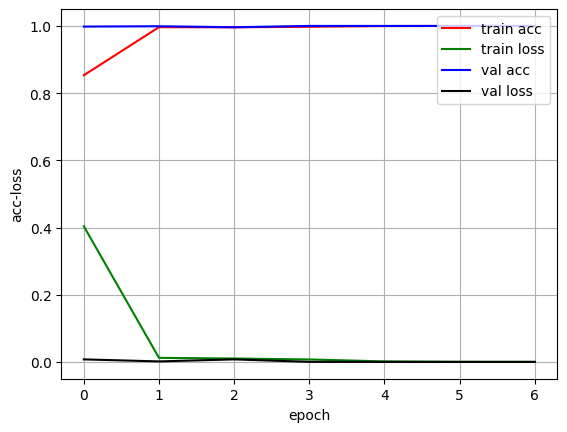

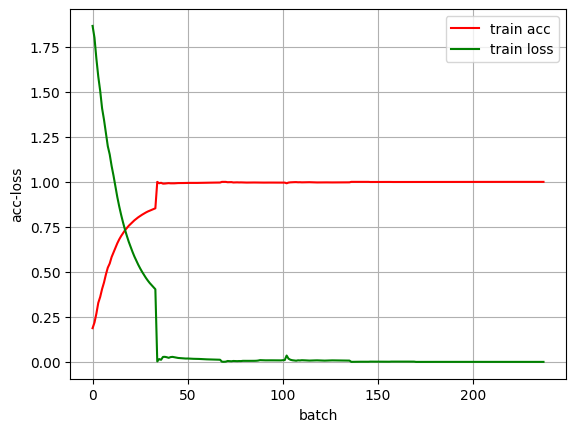

Process Keras_worker_ForkPoolWorker-102:
Process Keras_worker_ForkPoolWorker-103:
Traceback (most recent call last):
  File "/environment/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/environment/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/environment/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/environment/miniconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/environment/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/environment/miniconda3/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/environment/miniconda3/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._seml

In [28]:
vgg16(num_class=5,epochs=20)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [29]:
# RESNET Model

In [43]:
def resnet( num_class, epochs,savepath='./resnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:110]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[110:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=5, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
        #callbacks=[saveBestModel, history],
    )
    model.save('resnet.h5')
    model = load_model('resnet.h5')

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/3713144039.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.2359 - accuracy: 0.5634
Epoch 1: val_accuracy improved from -inf to 0.26953, saving model to ./resnet.h5
34/34 [==============================] - 21s 516ms/step - loss: 1.2359 - accuracy: 0.5634 - val_loss: 1.5849 - val_accuracy: 0.2695
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.8518
Epoch 2: val_accuracy improved from 0.26953 to 0.48828, saving model to ./resnet.h5
34/34 [==============================] - 17s 503ms/step - loss: 0.6061 - accuracy: 0.8518 - val_loss: 1.5594 - val_accuracy: 0.4883
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.9172
Epoch 3: val_accuracy improved from 0.48828 to 0.48926, saving model to ./resnet.h5
34/34 [==============================] - 21s 622ms/step - loss: 0.3903 - accuracy: 0.9172 - val_loss: 1.5426 - val_accuracy: 0.4893
Epoch 4/30
34/34 [==============================] - ETA: 0s - loss: 0.278

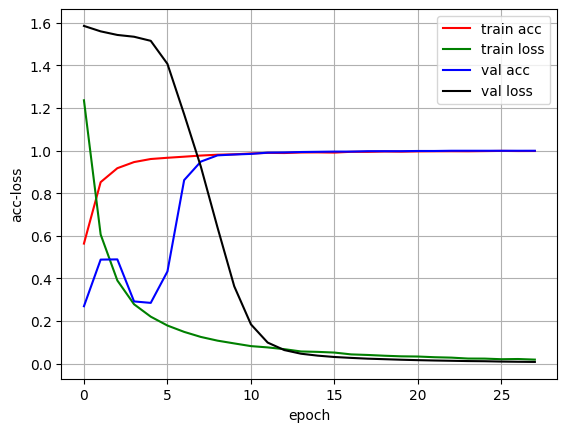

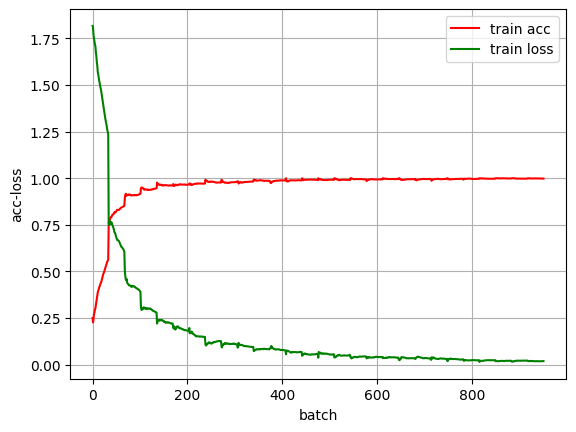

Process Keras_worker_ForkPoolWorker-477:
Traceback (most recent call last):
  File "/environment/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/environment/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/environment/miniconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/environment/miniconda3/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/environment/miniconda3/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/environment/miniconda3/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/environment/miniconda3/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [44]:
resnet(num_class=5,epochs=30)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [32]:
# Inception model

In [41]:
def inception( num_class, epochs,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='inception')
    opt = keras.optimizers.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=5, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #callbacks=[earlyStopping, saveBestModel, history],
        callbacks=[saveBestModel, history]
    )
    model.save('inception.h5')
    model = load_model('inception.h5')

/environment/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_19477/2032223731.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8130 - accuracy: 0.1871
Epoch 1: val_accuracy improved from -inf to 0.09180, saving model to ./inception.h5
34/34 [==============================] - 18s 373ms/step - loss: 1.8130 - accuracy: 0.1871 - val_loss: 2.0107 - val_accuracy: 0.0918
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5035 - accuracy: 0.3230
Epoch 2: val_accuracy improved from 0.09180 to 0.13770, saving model to ./inception.h5
34/34 [==============================] - 11s 329ms/step - loss: 1.5035 - accuracy: 0.3230 - val_loss: 1.8922 - val_accuracy: 0.1377
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2702 - accuracy: 0.4885
Epoch 3: val_accuracy improved from 0.13770 to 0.27246, saving model to ./inception.h5
34/34 [==============================] - 11s 332ms/step - loss: 1.2702 - accuracy: 0.4885 - val_loss: 1.6292 - val_accuracy: 0.2725
Epoch 4/30
34/34 [==============================] - ETA: 0s - lo

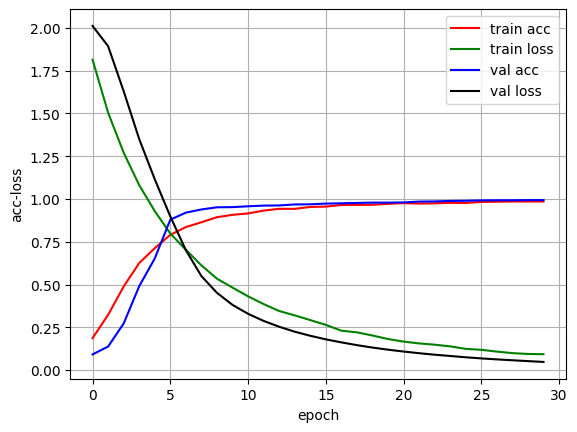

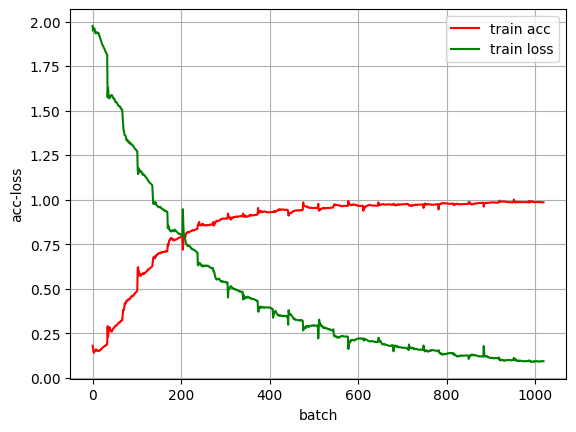

In [42]:
inception(num_class=5,epochs=30)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()